In [1]:
#must
import numpy as np
from homography import pyrs12, spaces
import cv2, h5py, deproject

In [2]:
#for showing
import matplotlib.pyplot as plt
import pptk

In [3]:
data = h5py.File('../recording_data/Vhdf5_20181112_165607.hdf5', 'r')

depth data to cloud

In [4]:
point = deproject.compute(data['depth'][70].astype(np.short()))
org = data['pcl_center'][...]
mat = data['trans_matrix'][...]
#homography process
point = np.dot(mat, (point - org).reshape((-1,3)).T).T.reshape((480, 640, 3))

In [5]:
def apply_1c_mask_to_3c_pointcloud(mask,point):
    new = np.copy(point)
    new[:,:,0] = np.where(mask,point[:,:,0], 0)
    new[:,:,1] = np.where(mask,point[:,:,1], 0)
    new[:,:,2] = np.where(mask,point[:,:,2], 0)
    return new

In [6]:
table = apply_1c_mask_to_3c_pointcloud(point[:,:,2]>0, point)
CLOUD_UPPER_MIN = 0.02  # 1cm, which exclude the plane
CLOUD_UPPER_MAX = 0.10  # 10cm

## split in 2 clouds Low and High
zm_upper_min = point[:,:,2] > CLOUD_UPPER_MIN
zp_upper_max = point[:,:,2] < CLOUD_UPPER_MAX
cloud_upper = zm_upper_min & zp_upper_max
cloud_upper.shape

(480, 640)

In [7]:
hight_image = np.where(cloud_upper,255,0).astype(np.uint8)

use a big Gaussia core to reduce the noice of the hand, >250 to reduce the edge

In [8]:
blur = np.where(cv2.GaussianBlur(hight_image,(9,9),0)>250,255,0).astype(np.uint8)

In [9]:
im2, contours, hierarchy=cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

we only have interest in the biggest area, hand in this case

In [10]:
contours = sorted(contours, key=lambda x: cv2.contourArea(x), reverse=True)

In [11]:
#should select the hand
#plt.imshow(cv2.drawContours(cv2.cvtColor(blur, cv2.COLOR_GRAY2RGB), contours[0], -1, (255,0,0), 3))

In [12]:
hull=cv2.convexHull(contours[0],returnPoints=True)

In [13]:
hull_point = hull.reshape(len(hull),2)
hull_vector = cv2.convexHull(contours[0],returnPoints=False)

we do not want the point that too close to the edge

In [14]:
def distance(p1, p2, threshold=15):
    p1 = np.array(p1)
    p2 = np.array(p2)
    result = np.sum(np.power(p2-p1,2),axis =1)
    return  result < threshold*threshold

In [15]:
def clustering_by_function(point, fun):
    cluster_label = np.full(len(point), 0)
    cluster_counter = 0
    for i in range(len(point)):
        if(cluster_label[i]!=0):
            continue
        cluster_counter += 1
        cluster_label[i] = cluster_counter
        d_2all = distance(point[i], point)
        for i2 in range(len(d_2all)):
            if(d_2all[i2]):
                if(cluster_label[i2]!=0):
                    continue
                cluster_label[i2] = cluster_counter
        
    return cluster_label.reshape(len(cluster_label),1), cluster_counter

In [16]:
cluster_label, cluster_counter = clustering_by_function(hull_point, distance)

In [17]:
result_point = np.concatenate((hull_point,cluster_label),axis=1)
result_vector = np.concatenate((hull_vector,cluster_label.reshape(len(cluster_label),1)),axis=1)

In [18]:
result_vector

array([[674,   1],
       [580,   2],
       [579,   2],
       [447,   3],
       [280,   4],
       [279,   4],
       [275,   4],
       [123,   5],
       [122,   5],
       [ 16,   6],
       [ 12,   6],
       [  4,   7],
       [  0,   7],
       [787,   8],
       [776,   9],
       [748,  10],
       [675,   1]])

In [19]:
result_point

array([[516, 170,   1],
       [503, 231,   2],
       [502, 232,   2],
       [461, 262,   3],
       [384, 271,   4],
       [380, 271,   4],
       [375, 269,   4],
       [236, 202,   5],
       [236, 195,   5],
       [242,  26,   6],
       [244,  19,   6],
       [248,   9,   7],
       [256,   0,   7],
       [314,   0,   8],
       [335,  17,   9],
       [378,  53,  10],
       [516, 169,   1]])

find the mean of each cluster

In [20]:
#array, the start of cluster label, the end.
def vstack_point(array, start, end):
    if start==end:
        return np.mean(array[array[:,2]==start],axis=0).astype(np.int32).reshape(1,3)
    return np.concatenate((np.mean(array[array[:,2]==start],axis=0).astype(np.int32).reshape(1,3),vstack_point(array, start+1,end)) , axis=0)


def vstack_vector(array, start, end):
    if start==end:
        return np.mean(array[array[:,1]==start],axis=0).astype(np.int32).reshape(1,2)
    return np.concatenate((np.mean(array[array[:,1]==start],axis=0).astype(np.int32).reshape(1,2),vstack_vector(array, start+1,end)) , axis=0)

In [21]:
clusted_vector = vstack_vector(result_vector, 1,cluster_counter)[:,0]
clusted_point = vstack_point(result_point, 1 ,cluster_counter)[:,:2]
#clusted_point_print = vstack_point(result, 1 ,cluster_counter)[:,:2].reshape(cluster_counter,1,2)

In [22]:
clusted_vector

array([674, 579, 447, 278, 122,  14,   2, 787, 776, 748], dtype=int32)

In [23]:
clusted_point

array([[516, 169],
       [502, 231],
       [461, 262],
       [379, 270],
       [236, 198],
       [243,  22],
       [252,   4],
       [314,   0],
       [335,  17],
       [378,  53]], dtype=int32)

In [24]:
#should show one point for hall
#plt.imshow(cv2.drawContours(cv2.cvtColor(blur, cv2.COLOR_GRAY2RGB), clusted_point_pint, -1, (255,0,0), 20))

In [25]:
defects = cv2.convexityDefects(contours[0], clusted_vector)

In [26]:
def print_defect(defects, image):
    image2 = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    for i in range(defects.shape[0]):
        s,e,f,d = defects[i,0]
        start = tuple(contours[0][s][0])
        end = tuple(contours[0][e][0])
        far = tuple(contours[0][f][0])
        cv2.line(image2,start,end,[0,255,0],2)
        cv2.circle(image2,far,5,[255,0,0],20)
    plt.imshow(image2)

In [27]:
#print_defect(defects, blur)

In [28]:
##all the hall that start and end a defect
hall_index = np.concatenate((defects[:,0,0],defects[:,0,1]))

In [29]:
maping = dict()
for i in hall_index:
    maping[i] = []

In [30]:
##collect defect for each hall
for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    maping[s].append(f)
    maping[e].append(f)

In [31]:
key = list(maping.keys())

In [32]:
#we dont need the dall that do not have 2 defect
for k in key:
    if(len(maping[k])<2):
        del maping[k]

In [33]:
dd_vector = np.array(list(maping.values()))##list of defects
hall_vector = np.array(list(maping.keys()))##list of hall

In [34]:
dd_point = contours[0][dd_vector][:,:,0]
hall_point = contours[0][hall_vector][:,0]

In [35]:
##cosine law  cos(A) = (b^2+c^2-a^2)/(2bc)
Ap = hall_point
Bp = dd_point[:,0]
Cp = dd_point[:,1]
##sqrt((p1-p2)**2)
a_distance = np.sum(np.power(Bp-Cp,2),axis =1)
b_distance = np.sum(np.power(Ap-Cp,2),axis =1)
c_distance = np.sum(np.power(Ap-Bp,2),axis =1)
Angel_A = np.arccos((b_distance + c_distance - a_distance)/(2 * np.sqrt(b_distance) * np.sqrt(c_distance))) * (180 / np.pi)

In [36]:
isfinger = Angel_A < 60

In [37]:
hall_point[isfinger].reshape(5,1,2)

array([[[516, 170]],

       [[236, 195]],

       [[379, 270]],

       [[461, 262]],

       [[502, 232]]], dtype=int32)

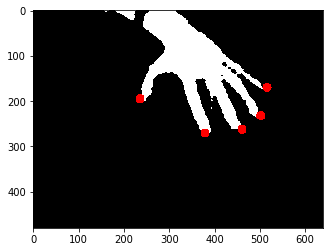

In [38]:
plt.imshow(cv2.drawContours(cv2.cvtColor(blur, cv2.COLOR_GRAY2RGB), hall_point[isfinger].reshape(5,1,2), -1, (255,0,0), 20))

In [39]:
#return
hall_point[isfinger]

array([[516, 170],
       [236, 195],
       [379, 270],
       [461, 262],
       [502, 232]], dtype=int32)